# Preparing the data

In this notebook we prepare the mined data so that we can more easily fit a model on it.

## 1. Data preprocessing

As a first step, we will transform all of the mined data into a tabular data structure.

In [1]:
import os
import pandas as pd

# Create empty pandas data frame
df = pd.DataFrame(columns = ['review_id', 'app_id', 'review_text', 'label'])

# Set the location of folder in which the data is stored
data_folder = "C:/Users/wille/spark/MyData/"
mined_dirs = os.listdir(data_folder)

# Iterate over all mined data
for dir in mined_dirs:

    # Get files in each folder and ...
    files = os.listdir(data_folder + dir)

    # if there is a file containing mined data:
    if "part-00000" in files:

        # 1) Read its content
        mined_data_pathname = data_folder + dir + '/part-00000'
        file = open(mined_data_pathname)
        content = file.read()

        # 2) Split it into the different reviews (which are separated by an 'enter')
        reviews = content.split('\n')

        # 3) Remove all empty reviews (artefact of the mining process)
        reviews = [review for review in reviews if review != ""]

        # 4) For each review
        for review in reviews:

            # 4.0) Set some useful constants to specify the lengths of the keys used to extract the desired information from each review.
            NCHAR_REVIEW_ID_KEY = 15
            NCHAR_APP_ID_KEY = 13
            NCHAR_REVIEW_TEXT_KEY = 18

            # 4.1) Extract review_id, app_id, review_text and label using string slicing based on the indices 
            idx_app_id = review.find(', "app_id": ')
            idx_review_text = review.find(', "review_text": ')
            idx_label = review.find(', "label": ')

            review_id = review[NCHAR_REVIEW_ID_KEY:(idx_app_id - 1)]
            app_id = review[(idx_app_id + NCHAR_APP_ID_KEY):(idx_review_text - 1)]
            review_text = review[(idx_review_text + NCHAR_REVIEW_TEXT_KEY):(idx_label - 1)]
            label = review[-2]

            # 4.2) Store these values as a row in the data frame
            row = {'review_id' : review_id, 'app_id' : app_id, 'review_text' : review_text, 'label' : label}
            df.loc[len(df)] = row

df.head(10)

,review_id,app_id,review_text,label
0,136510302,2103530,"I simply love it, it's a great game!",1
1,136509602,2349550,Gifted word: Grace,1
2,136510134,1685730,"It's pretty good! If this was more expanded, i...",1
3,136510117,1685730,"I recommend it, I had a great time playing the...",1
4,136509657,2364130,simple point and click game without much content,0
5,136511145,1829810,If puppet combo made this everyone would play ...,1
6,136511817,2102490,Nice sim game.,1
7,136511667,2102490,"It's a fun game, and always a few surprises wi...",1
8,136510517,2299240,"Fated word: Life, I was on the fence of which ...",1
9,136510715,2349550,My gifted word: Strenght\n\nIt was pleasure to...,1


All of the columns in the dataframe constructed above are of type 'string'. Since both the 'id'-columns as well as the column containing the label of the review are integers, we also store them as such. The following block of code will throw an error due to a problem in the 'app_id'-column meaning that it requires some further attention. The other two columns get converted without issue.

In [2]:
try:
    df["label"] = df["label"].astype(int)
    print("Type of 'label'-column changed succesfully.")
except:
    print("An error occured in the 'label'-column.")

try:
    df["app_id"] = df["app_id"].astype(int)
    print("Type of 'app_id'-column changed succesfully.")
except:
    print("An error occured in the 'app_id'-column.")

try:
    df["review_id"] = df["review_id"].astype(int)
    print("Type of 'review_id'-column changed succesfully.")
except:
    print("An error occured in the 'review_id'-column.")

Type of 'label'-column changed succesfully.
An error occured in the 'app_id'-column.
Type of 'review_id'-column changed succesfully.


We investigate the problem further by looking at which values cannot be converted to an integer and hence causing the `.astype()` method to throw an error.

In [3]:
# Store the number of rows in the data frame.
n = df.shape[0]

# Construct an empty set in which we will store all problematic app_ids.
error_app_ids = set()

# For each row in the data frame...
for i in range(n):
    # Try to convert the value of 'app_id' to an integer.
    try:
        dummy = int(df.at[i, 'app_id'])
    
    # If that fails, store the app_id in question
    except:
        error_app_ids.add(df.at[i, 'app_id'])

print(error_app_ids)

{'1798010,1798020'}


Only the app_id _'1798010,1798020'_ gives an error. Most likely, it corresponds to a game that has two app ids and hence we simply represent these games with the app_id _'1798010'_ (i.e. the first id). Having done so, the conversion of the 'app_id'-column to an integer type column runs without issue

In [4]:
# Change the problematic app_id
df['app_id'] = df.apply(lambda row: '1798010' if row['app_id'] == '1798010,1798020' else row['app_id'], axis = 1)

# Try to change the type of the 'app_id'-column again.
try:
    df["app_id"] = df["app_id"].astype(int)
    print("Type of 'app_id'-column changed succesfully.")
except:
    print("An error occured in the 'app_id'-column.")

Type of 'app_id'-column changed succesfully.


## 2. Data inspection

It can be good to know some basic properties of the data set and more importantly, fix any issues that might be present. To this end, we can ask the following questions:
* Are there any duplicate reviews mined?
* Are there missing values in the data set?
* How many positive and negative reviews are there?
* How many different games are there in total in the data set?

We will investigate each of these different questions in the following.

### 2.1. Are there any duplicate reviews mined?
If so, we will delete the duplicates. Since each review comes with its own review identification number, all we have to do is to look for duplicates in the 'review_id'-column.

In [7]:
import numpy as np

# To look for duplicates in the 'review_id'_column:

# Create a set of all the unique review_ids
review_id_unique = set(np.unique(df['review_id'].array))

# Check to see if there are duplicate rows
if len(review_id_unique) != n:
    print("Duplicate rows detected. The number of unique ids is " + str(len(review_id_unique)) + \
          " whereas the total number of rows in the data frame is " + str(n) + ".")
    print("This means that there are a total of " + str(n - len(review_id_unique)) + " duplicates.")
else:
    print("No duplicate rows detected.")

Duplicate rows detected. The number of unique ids is 2228 whereas the total number of rows in the data frame is 2385.
This means that there are a total of 157 duplicates.


In [8]:
row_idx_to_remove = []

# Iterate over all the rows in the data frame and for each...
for i in range(n):
    
    # 1) get the review id
    review_id = df.at[i, 'review_id']
    
    # 2) check if this review id was not yet seen in the data frame in previous rows. To that end, first check if the
    #    set of not-yet-seen review ids is empty. If that is the case, we know that we have seen all review ids and hence
    #    the current review id is a duplicate.
    if review_id_unique == None:
        row_idx_to_remove += [i]
    
    # 2.1) If there are still unseen review ids left, check if the current review id is unseen
    else:
        review_not_yet_seen = review_id in review_id_unique
    
        # 3.1) if it was not yet seen...
        if review_not_yet_seen:
            # remove it from the net-yet-seen-reviews set.
            review_id_unique.remove(review_id)

        # 3.2) if it was already seen...
        else:
            # Store index of row to be removed
            row_idx_to_remove += [i]

# We can check that the number of indices to remove matches the number of duplicate rows detected.
print("Number of indices to remove: " + str(len(row_idx_to_remove)))

Number of indices to remove: 157


In [10]:
# Finally, we can remove the duplicate rows
df.drop(index = row_idx_to_remove, inplace = True)

# We check that all of the duplicates have been removed, as we intended.
review_id_unique = set(np.unique(df['review_id'].array))
print("There are now " + str(len(review_id_unique)) + " unique reviews in the data set.")

# Also, recompute the number of rows in the data set
n = df.shape[0]

There are now 2228 unique reviews in the data set.


We can now be sure that all reviews in the current data set are unique.

### 2.2. Are there missing values in the data set?
If so, proper action needs to be taken.

In [27]:
rows_with_missings = df.isnull().any(axis = 1)
df[rows_with_missings]

,review_id,app_id,review_text,label


Conveniently, there are no missing values.

### 2.3. How many positive and negative reviews are there?
It was mentioned in class that we should have at least 100 of each. Moreover, it could be useful to know if we are dealing with inballanced data and if so, how inballanced the data really is.

In [36]:
tot_pos = sum(df['label'])
tot_neg = sum(1 - df['label'])

print("Total number of positive reviews is " + str(tot_pos) + ". This is " + str(np.round(100*tot_pos/n, 2)) + "% of the data set.")
print("Total number of negative reviews is " + str(tot_neg) + ". This is " + str(np.round(100*tot_neg/n, 2)) + "% of the data set.")

Total number of positive reviews is 1897. This is 85.14% of the data set.
Total number of negative reviews is 331. This is 14.86% of the data set.


Hence we see that there is quite some inballance in the data set. Depending on the focus of the prediction (accuracy, high precision, high recall, etc...) a proper loss function should be selected.

### How many different games are there in the data set?
Maybe there are games in the data set that are really good and hence get a lot of positive reviews or, similarly, there are games that are bad and get a lot of negative reviews. It could be useful information to know since there might be some specific words related to each of these games (in a medieval game, the word 'castle' might be frequently used in its reviews) that the future model might then learn to be indicators of positive/negative reviews.

Perhaps we want the model to learn this, perhaps not. But at the very least being aware that it could be an issue is already valuable. 

In [39]:
# Create a set of all the unique app_ids
app_id_unique = set(np.unique(df['app_id'].array))

# Compute how many different games there are
print("There are " + str(len(app_id_unique)) + " different games in the data set.")

There are 204 different games in the data set.


In [47]:
# To investigate if there are games that are generally regarded as very good/bad, we look at the proportion of positive to
# negative reviews for each.

# Define a value at which the proportions will be capped
PROPORTION_CAP = 10

# Initialise an array that will store all proportions
proportion_positive_negative = []

# For each game...
for game in app_id_unique:
    
    # Get the subset of the data frame pertaining to the game in question
    game_df = df.loc[df['app_id'] == game]
    
    # Compute the proportion of positive to negative reviews (we add a small number to the denominator to prevent devision
    # by zero problems).
    prop = np.min([sum(game_df['label'])/(sum(1 - game_df['label']) + 10**(-10)), PROPORTION_CAP])
    
    # Store it
    proportion_positive_negative += [prop]

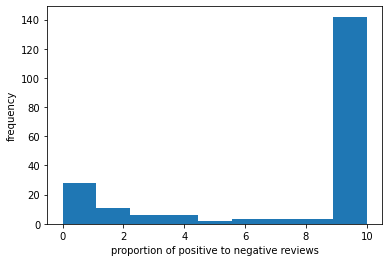

In [76]:
from matplotlib import pyplot as plt 

plt.hist(proportion_positive_negative, bins = 'auto')
plt.xlabel("proportion of positive to negative reviews")
plt.ylabel("frequency")
plt.show()

The plot can be seen to show a slight U-shape: the frequencies of games with predominantly positive or negative reviews is elevated. This effect is especially pronounced for the games with a lot of positive reviews, which is logical since there are a lot more positive reviews in the data set.

As already mentioned before, this could require some care when making the model. For example, suppose that a lot of games that have a high positive to negative ratio are Super Mario games. It would then seem reasonable that the model might associate the word _Mario_ with a high score. However, if a next Super Mario game turns out to be very bad, our model will have trouble with predicting the labels of the (very likely negative) reviews for this game. Likewise, if the main character of another unrelated game is also named _Mario_, it might get confused.

Therefore if possible, we will try to also include some model interpretability into our analysis and investigate which words the model pays a lot of attention to when making its predictions.

## 3. Save data frame for further analysis
All that's left to do is to save the preprocessed data, to be used in the next notebook.

In [79]:
df.to_csv("data/review_data.csv", index = False)